In [26]:
import numpy as np
import pandas as pd

In [27]:
def read_data(fname):
    """ 
    Reads a CSV file into a pandas Dataframe, identifies and removes duplicate ones, and prints information
    about the shape of the data before and after duplicate removal.
    Parameter:
    -------
    fname: str
        The filename or path to the CSV file to be read.
    returns:
    -------
    pd.Dataframe
        The dataframe containing the data from the CSV file after removing duplication

    """
    df = pd.read_csv(fname)
    print("Data shape raw               : ", df.shape)
    num_duplicated = df.duplicated().sum()
    print("Number of duplicate order id : ",num_duplicated)
    df = df.drop_duplicates(keep='last')
    print("Data shape after dropping    : ", df.shape)
    print("Data shape final             : ", df.shape)
    return df

In [28]:
data = read_data(fname='./dataset/pd_loan_data_train.csv')

Data shape raw               :  (20400, 15)
Number of duplicate order id :  0
Data shape after dropping    :  (20400, 15)
Data shape final             :  (20400, 15)


Data Preparation and EDA

In [29]:
from sklearn.model_selection import train_test_split

def split_input_output(data,target_col):
    """
    Splits the dataset into training and testing sets for both features (X) and target (y) using stratified sampling.

    Parameters:
    -----------
    X : pd.DataFrame or np.ndarray
        The feature set (input data) to be split.
    
    y : pd.Series or np.ndarray
        The target variable corresponding to the feature set.
    
    test_size : float
        The proportion of the dataset to include in the test split. 
        Should be between 0.0 and 1.0.
    
    seed : int
        The random seed for reproducibility of the split.
    
    Returns:
    --------
    tuple of pd.DataFrame/np.ndarray:
        - X_train : pd.DataFrame or np.ndarray
            The feature set for training.
        - X_test : pd.DataFrame or np.ndarray
            The feature set for testing.
        - y_train : pd.Series or np.ndarray
            The target variable for training.
        - y_test : pd.Series or np.ndarray
            The target variable for testing.
    
    Notes:
    ------
    - The function uses `train_test_split` from `sklearn.model_selection` to perform the split.
    - Stratified sampling is applied to ensure the target variable distribution is maintained between the training and test sets.
    """
    output_data = data[target_col]
    data = data.drop(target_col, axis = 1)
    print(f'X shape: {data.shape}')
    print(f'y shape: {output_data.shape}')
    return data, output_data

In [30]:
X, y = split_input_output(data=data, target_col='good_bad')

X shape: (20400, 14)
y shape: (20400,)


In this dataset, the target variable Good_Bad exhibits significant class imbalance, with approximately 85.7% of the loans being classified as non-default (non-default, class 1), and only 14.3% being classified as default (default, class 0). Such class imbalance can cause the model to be biased toward predicting the majority class (non-default) more often, which may result in the model being less sensitive to the minority class (default).

Thus, in this case, resampling techniques like SMOTE and oversampling are avoided due to the risk of overfitting, and undersampling is avoided because it may result in the loss of valuable information from the majority class. Instead, metrics such as F1-score and AUC are used to fairly assess the model’s performance, particularly in the context of class imbalance.

In [31]:
y.value_counts(normalize=True)

good_bad
1    0.857206
0    0.142794
Name: proportion, dtype: float64

In [32]:
def split_cat_num_col(df:pd.DataFrame) -> tuple:
    """
    Splits categorical and numerical columns from a DataFrame.
    Boolean columns are treated as categorical.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    tuple[pd.DataFrame, pd.DataFrame]: 
        - List of categorical columns (including boolean columns)
        - List of numerical columns
    """
    cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
    num_cols = df.select_dtypes(include=['number']).columns.tolist()

    return cat_cols, num_cols

In [33]:
cat_cols, num_cols = split_cat_num_col(X)

In [34]:
100 * (X.isna().sum(0)/len(X))

loan_id                        0.000000
grade                          0.000000
home_ownership                 0.000000
purpose                        0.000000
verification_status            0.000000
term                           0.000000
emp_length_int                 0.000000
mths_since_issue_d             0.000000
int_rate                       0.000000
mths_since_earliest_cr_line    0.000000
acc_now_delinq                 6.647059
inq_last_6mths                 0.000000
annual_inc                     0.000000
dti                            0.000000
dtype: float64

We can see that the column acc_now_delinq contains some NaN (missing) values. The value distribution is highly skewed, as the vast majority of entries are 0, and only a few rows contain values greater than zero

In [35]:
data['acc_now_delinq'].value_counts()

acc_now_delinq
0.0    18969
1.0       64
2.0       10
3.0        1
Name: count, dtype: int64

Because of this imbalance, using median imputation is a reasonable approach — especially when the data is skewed. In this case, the median value is 0, which also logically means the borrower currently has no delinquencies.

Thus, instead of using a separate imputer object, we can directly fill the missing values with 0, as it aligns both statistically and contextually with the data.

In [36]:
pd.set_option('display.max_colwidth', None)

listItem = []
for col in data[cat_cols]:
  listItem.append([col, data[col].nunique(), data[col].unique()])

pd.DataFrame(columns=['nama kolom', 'jumlah nilai unique', 'nilai unique'], data=listItem)

,nama kolom,jumlah nilai unique,nilai unique
0,grade,7,"[C, B, E, A, D, F, G]"
1,home_ownership,3,"[RENT, MORTGAGE, OWN]"
2,purpose,14,"[debt_consolidation, major_purchase, home_improvement, credit_card, medical, vacation, other, moving, small_business, house, wedding, car, educational, renewable_energy]"
3,verification_status,3,"[Verified, Source Verified, Not Verified]"
4,term,2,"[60 months, 36 months]"


In [37]:
for column in data.columns:
    uniquue_values = data[column].unique()
    num_unique = len(uniquue_values)
    print(f'feature : {column}')
    print(f'num unique values:{uniquue_values}')
    print("-" * 50)

feature : loan_id
num unique values:[14840 20011  8415 ... 18441 26253  8050]
--------------------------------------------------
feature : grade
num unique values:['C' 'B' 'E' 'A' 'D' 'F' 'G']
--------------------------------------------------
feature : home_ownership
num unique values:['RENT' 'MORTGAGE' 'OWN']
--------------------------------------------------
feature : purpose
num unique values:['debt_consolidation' 'major_purchase' 'home_improvement' 'credit_card'
 'medical' 'vacation' 'other' 'moving' 'small_business' 'house' 'wedding'
 'car' 'educational' 'renewable_energy']
--------------------------------------------------
feature : verification_status
num unique values:['Verified' 'Source Verified' 'Not Verified']
--------------------------------------------------
feature : term
num unique values:['60 months' '36 months']
--------------------------------------------------
feature : emp_length_int
num unique values:[ 7  2  0 10  1  3  6  4  5  8  9]
-----------------------------

We can also see that the term column only has two unique values, so it can be converted to an integer. Meanwhile, the purpose column has high cardinality (14 categories), so we can simplify it by keeping only the top 4–5 most frequent categories and grouping the rest into 'other'.

In [38]:
def feature_engineering(df):

    df = df.copy()  

    if 'loan_id' in df.columns:
        df.drop('loan_id', axis=1, inplace=True)

    if 'acc_now_delinq' in df.columns:
        df.drop('acc_now_delinq', axis=1, inplace=True)

    if 'acc_now_delinq' in df.columns:
        df['acc_now_delinq'] = df['acc_now_delinq'].fillna(0)
    if 'term' in df.columns:
        df['term'] = df['term'].astype(str).str.replace(' months', '').astype(int)

    
    if 'purpose' in df.columns:
        main_purposes = ['debt_consolidation', 'credit_card', 'home_improvement',
                         'major_purchase']
        df['purpose'] = df['purpose'].apply(
            lambda x: x if x in main_purposes else 'other'
        )
    return df

In [39]:
X_feature_engineering = feature_engineering(X)

In [40]:
cat_cols, num_cols = split_cat_num_col(X_feature_engineering)

In [41]:
data.columns

Index(['loan_id', 'grade', 'home_ownership', 'purpose', 'verification_status',
       'term', 'emp_length_int', 'mths_since_issue_d', 'int_rate',
       'mths_since_earliest_cr_line', 'acc_now_delinq', 'inq_last_6mths',
       'annual_inc', 'dti', 'good_bad'],
      dtype='object')

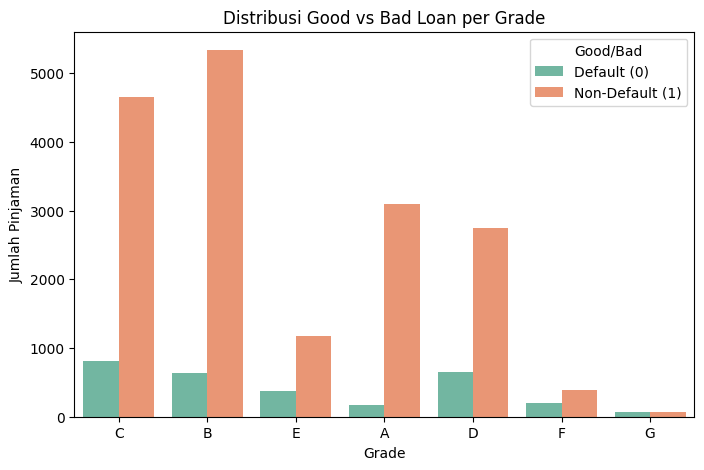

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='grade', hue='good_bad', palette='Set2')
plt.title('Distribusi Good vs Bad Loan per Grade')
plt.xlabel('Grade')
plt.ylabel('Jumlah Pinjaman')
plt.legend(title='Good/Bad', labels=['Default (0)', 'Non-Default (1)'])
plt.show()


This distribution suggests that loan grade is a strong predictor of loan performance — the lower the grade, the higher the risk of default.

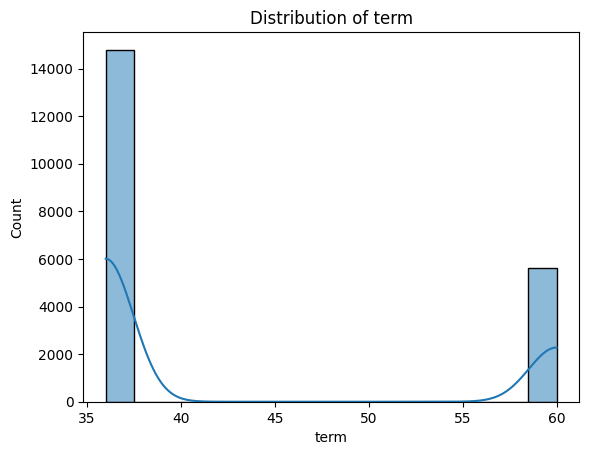

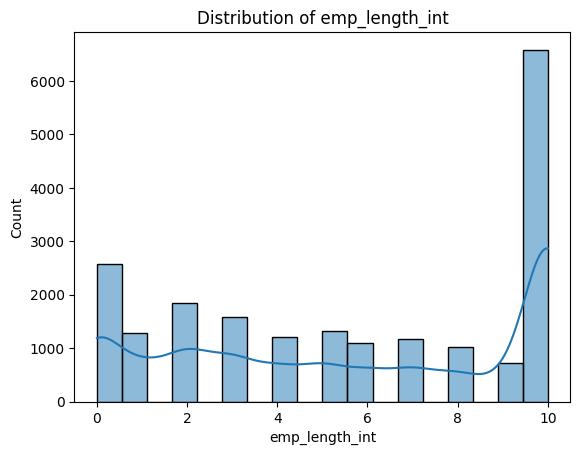

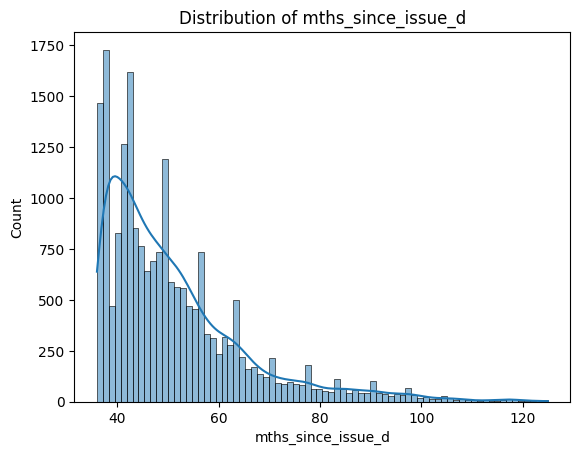

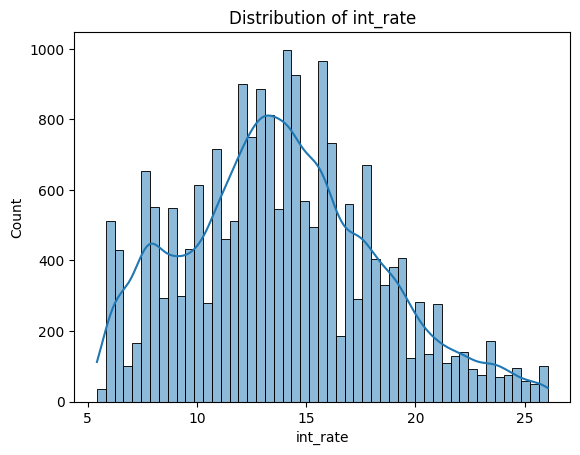

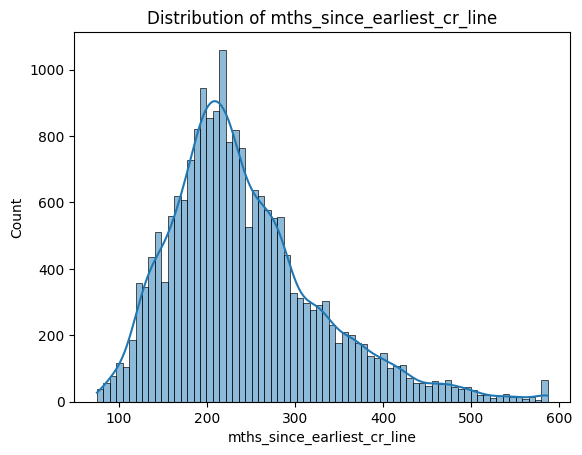

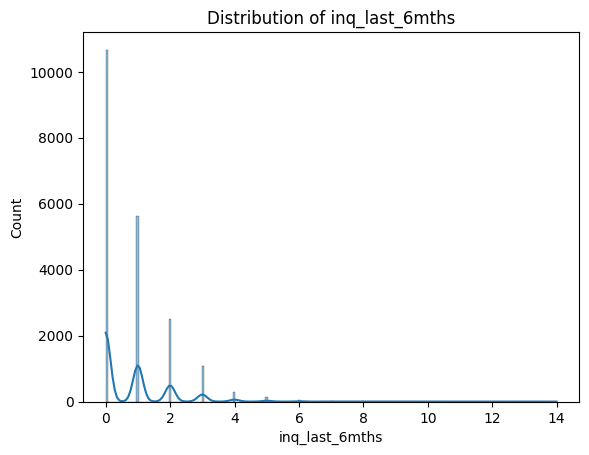

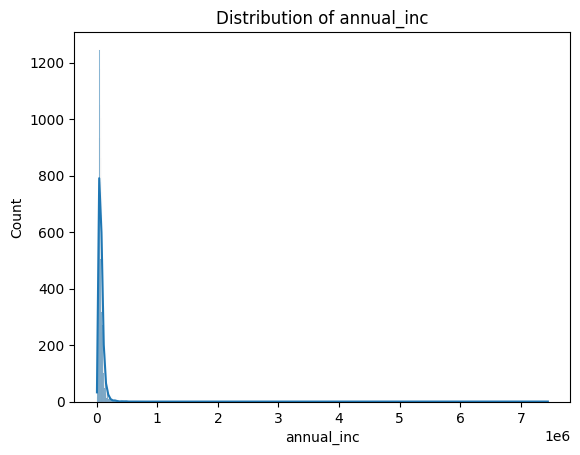

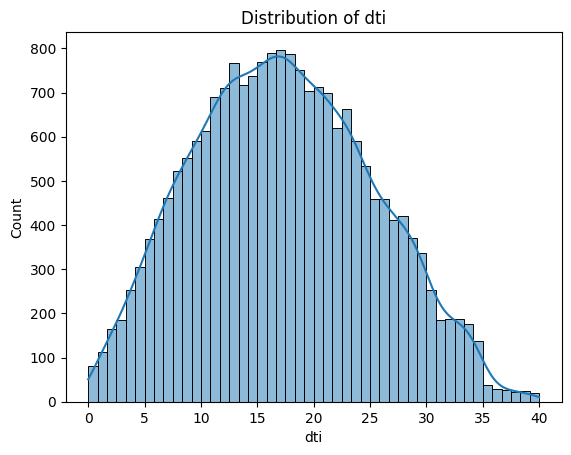

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in num_cols:
    sns.histplot(data=X_feature_engineering, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

checking correlation

In [44]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Inisialisasi list untuk hasil
p_values = []
interpretasi = []
colss = ['home_ownership', 'purpose', 'verification_status']   # Daftar nama kolom kategorikal

# Loop untuk menghitung p-value chi2 untuk setiap kolom kategorikal
for col in colss:
    # Encoding kategorikal ke numerik
    le = LabelEncoder()
    X_encoded = le.fit_transform(X_feature_engineering[col])  # Mengubah menjadi array numerik

    # Menghitung chi2
    chi2_stat, p_value = chi2(X_encoded.reshape(-1, 1), y)  # Melakukan uji chi2

    # Menyimpan hasil
    p_values.append(p_value[0])  # Chi2 mengembalikan array, kita ambil nilai pertama
    if p_value[0] < 0.05:  # Bandingkan nilai pertama p-value
        interpretasi.append('ada korelasi')
    else:
        interpretasi.append('ga ada korelasi')

# Menampilkan hasil seleksi fitur
hasil = pd.DataFrame({'nama kolom': colss, 'p-value': p_values, 'hasil': interpretasi})
print(hasil)

            nama kolom       p-value         hasil
0       home_ownership  2.205688e-15  ada korelasi
1              purpose  5.139465e-12  ada korelasi
2  verification_status  3.051899e-09  ada korelasi


In [45]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
import pandas as pd

# Kolom ordinal tunggal
cat_ord = ['grade']  # Harus list
ordinal_mapping = {
    'grade': ['A', 'B', 'C','D','E','F','G']
}

# Encode
encoder = OrdinalEncoder(categories=[ordinal_mapping[col] for col in cat_ord])
X_encoded = encoder.fit_transform(X_feature_engineering[cat_ord])

# Chi-square test
chi2_stat, p_values = chi2(X_encoded, y)

# Interpretasi
interpretasi = ['ada korelasi' if p < 0.05 else 'ga ada korelasi' for p in p_values]
hasil = pd.DataFrame({
    'nama kolom': cat_ord,
    'p-value': p_values,
    'hasil': interpretasi
})

print(hasil)


  nama kolom        p-value         hasil
0      grade  1.680433e-165  ada korelasi


In [46]:
from scipy.stats import kendalltau
import pandas as pd
# Feature selection Numerical columns
p_values = []
interpretasi = []
cols = []

for col in num_cols:
  corr_coef, p_value = kendalltau(X_feature_engineering[col], y)

  p_values.append(p_value)
  cols.append(col)

  if p_value < 0.05:
    interpretasi.append('ada korelasi')
  else :
    interpretasi.append('ga ada korelasi')

pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi,
              'P_value': p_values})

,nama kolom,hasil,P_value
0,term,ada korelasi,4.583742e-27
1,emp_length_int,ada korelasi,6.775160e-08
2,mths_since_issue_d,ada korelasi,1.078993e-43
3,int_rate,ada korelasi,2.128722e-165
4,mths_since_earliest_cr_line,ada korelasi,1.975446e-05
5,inq_last_6mths,ada korelasi,1.609607e-40
6,annual_inc,ada korelasi,1.734404e-21
7,dti,ada korelasi,7.017943e-20


we can see acc now delinq doesnt have correlation so we might as well drop that

In [47]:
X_feature_engineering = feature_engineering(X_feature_engineering)

also checking the corr between num cols

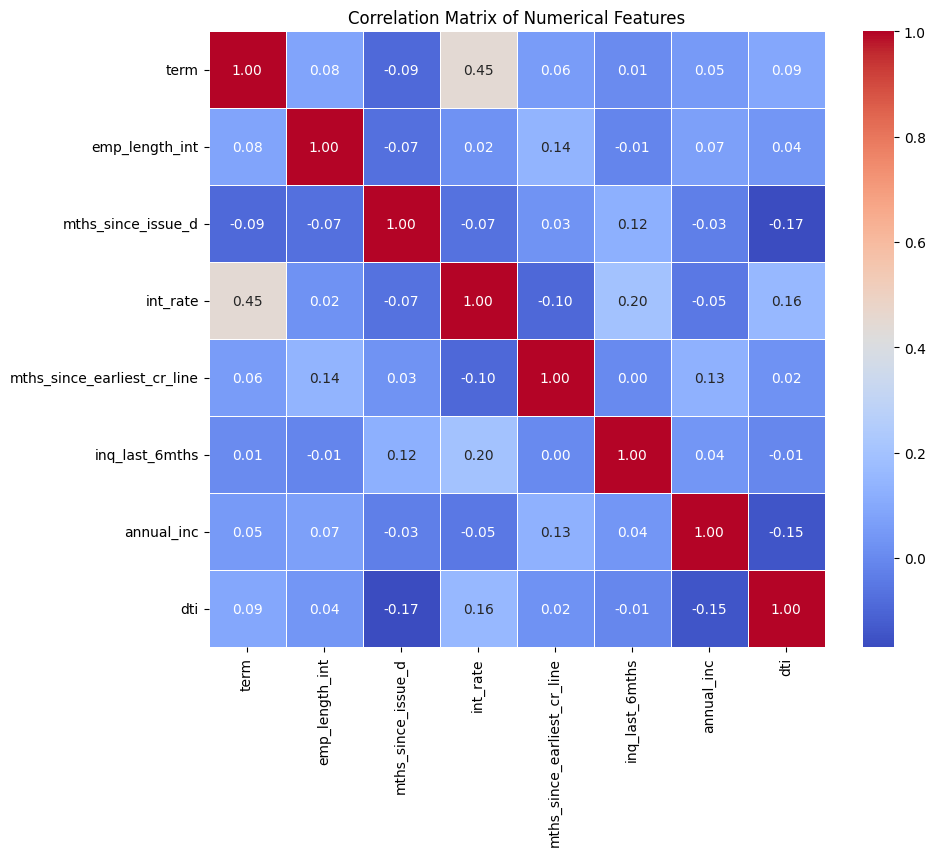

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hanya data numerik yang dibutuhkan
corr_matrix = X_feature_engineering[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


- Most features here are weakly correlated with each other.

- There are no strong multicollinearities to worry about.

- Some small positive/negative trends (e.g., between int_rate, inq_last_6mths, and dti) could still be useful in modeling or analysis.

removing outliers

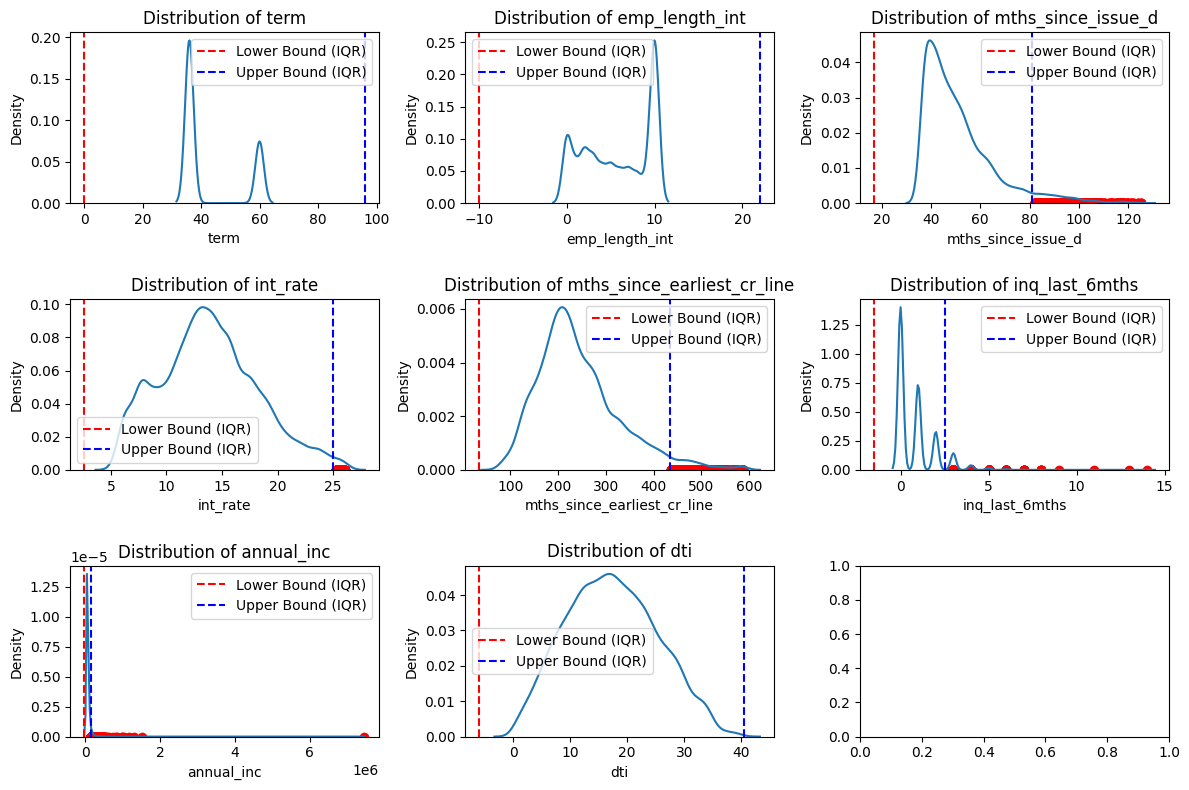

In [49]:


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = ax.flatten()

for i, col in enumerate(X_feature_engineering[num_cols].columns):
    sns.kdeplot(X_feature_engineering[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    
    # Calculate IQR
    q1 = np.percentile(X_feature_engineering[col], 25)
    q3 = np.percentile(X_feature_engineering[col], 75)
    iqr = q3 - q1
    
    # Define outlier bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Plot IQR bounds
    axes[i].axvline(lower_bound, color='red', linestyle='--', label='Lower Bound (IQR)')
    axes[i].axvline(upper_bound, color='blue', linestyle='--', label='Upper Bound (IQR)')
    
    # Identify outliers
    outliers = X_feature_engineering[(X_feature_engineering[col] < lower_bound) | (X_feature_engineering[col] > upper_bound)]
    axes[i].scatter(outliers[col], np.zeros_like(outliers[col]), color='red')

    axes[i].legend()

plt.tight_layout()
plt.show()

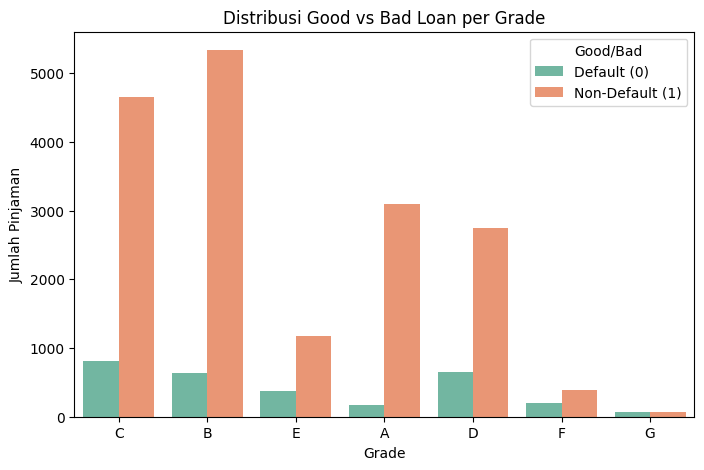

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='grade', hue='good_bad', palette='Set2')
plt.title('Distribusi Good vs Bad Loan per Grade')
plt.xlabel('Grade')
plt.ylabel('Jumlah Pinjaman')
plt.legend(title='Good/Bad', labels=['Default (0)', 'Non-Default (1)'])
plt.show()


Should we add new independent variable to increase predictive power?
Adding new independent variables can theoretically improve a model's predictive power, but only if the new features provide meaningful and relevant information. In practice, I tried creating some engineered features such as:

loan_to_income = interest rate divided by annual income,

debt_burden = a combination of debt-to-income ratio and interest rate,

converting term from string to integer.

However, these additions actually led to overfitting. The model performed better on the training set but worse on the validation and test sets. This suggests that the new features may have captured patterns specific to the training data that don’t generalize well.

In conclusion, adding features should always be followed by careful evaluation through cross-validation and testing on unseen data. Not all engineered features will improve performance—some might even hurt it.

Model Developement

## Models Developed

To solve this classification problem, I developed and evaluated three different algorithms:

1. **Logistic Regression**  
   Used as a baseline model for its simplicity and interpretability. It provided a benchmark and insights into feature importance.

2. **Random Forest**  
   An ensemble method that handles non-linear relationships and reduces overfitting through bootstrapping and feature randomness.

3. **XGBoost**  
   A powerful gradient boosting method known for its performance and ability to handle complex patterns and imbalanced data.

---

## Model Optimization

To optimize the models, I performed hyperparameter tuning using `GridSearchCV` with stratified k-fold cross-validation:

- **Logistic Regression**: tuned regularization strength (`C`)
- **Random Forest**: tuned number of trees, maximum depth, and minimum samples
- **XGBoost**: tuned learning rate, max depth, number of estimators, and regularization parameters

---

## Ensuring Model Stability

To ensure the models were stable and generalizable:

- I used **StratifiedKFold** to preserve class distribution across folds.
- Evaluated models using **validation metrics** such as F1-score and ROC-AUC, not just accuracy.
- Monitored the **gap between training and validation scores** to detect overfitting.

---

## Use of Ensemble Methods

Yes, I used ensemble methods to improve model performance:

- **Random Forest**: uses **bagging** to reduce variance and increase robustness.
- **XGBoost**: uses **boosting** to sequentially reduce bias and build a strong learner.

These ensemble techniques significantly improved performance compared to the baseline logistic regression model.


In [50]:
from sklearn.model_selection import train_test_split
def split_train_test(X,y,test_size, seed):
    """
    Splits the dataset into training and testing sets for both features (X) and target (y) using stratified sampling.

    Parameters:
    -----------
    X : pd.DataFrame or np.ndarray
        The feature set (input data) to be split.
    
    y : pd.Series or np.ndarray
        The target variable corresponding to the feature set.
    
    test_size : float
        The proportion of the dataset to include in the test split. 
        Should be between 0.0 and 1.0.
    
    seed : int
        The random seed for reproducibility of the split.
    
    Returns:
    --------
    tuple of pd.DataFrame/np.ndarray:
        - X_train : pd.DataFrame or np.ndarray
            The feature set for training.
        - X_test : pd.DataFrame or np.ndarray
            The feature set for testing.
        - y_train : pd.Series or np.ndarray
            The target variable for training.
        - y_test : pd.Series or np.ndarray
            The target variable for testing.
    
    Notes:
    ------
    - The function uses `train_test_split` from `sklearn.model_selection` to perform the split.
    - Stratified sampling is applied to ensure the target variable distribution is maintained between the training and test sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed,stratify=y)
    print(f'X_train shape: {X_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_test shape: {y_test.shape}')
    
    return X_train, X_test, y_train, y_test

X_train, X_valid, y_train, y_valid = split_train_test(X=X_feature_engineering,y=y, test_size=0.2, seed=123)

X_train shape: (16320, 12)
X_test shape: (4080, 12)
y_train shape: (16320,)
y_test shape: (4080,)


In [51]:
train_data = pd.concat([X_train,y_train],axis=1)
train_data.head()

,grade,home_ownership,purpose,verification_status,term,emp_length_int,mths_since_issue_d,int_rate,mths_since_earliest_cr_line,inq_last_6mths,annual_inc,dti,good_bad
10309,B,OWN,credit_card,Verified,36,0,52,12.35,151,2,22000.0,25.53,0
12108,D,MORTGAGE,debt_consolidation,Verified,60,10,48,19.52,223,0,130000.0,23.32,1
12106,A,MORTGAGE,credit_card,Not Verified,36,10,37,7.49,358,0,80000.0,25.46,1
15452,A,RENT,other,Verified,36,0,64,7.62,129,3,28800.0,23.24,1
11643,B,RENT,debt_consolidation,Source Verified,36,0,45,12.49,92,0,24000.0,11.45,1


In [52]:
idx_to_drop = train_data[
    (train_data['annual_inc'] > 300000) |
    (train_data['dti'] > 45) |
    (train_data['inq_last_6mths'] > 7) |
    (train_data['mths_since_earliest_cr_line'] > 500)
].index.tolist()


In [53]:
train_data_cleaned = train_data.drop(index=idx_to_drop).copy()

In [54]:
X_train_dropped, y_train_dropped = split_input_output(train_data_cleaned,['good_bad'])

X shape: (16055, 12)
y shape: (16055, 1)


Since we already impute it, we can skip imputing part, but just incase the there are transfer learning, we might as well need to include it

In [55]:
from sklearn.impute import SimpleImputer
def num_imputer_fit(data):
    ''' 
    Fit a SimpleImputer to the numerical data using the median strategy.

    Parameters

    data : pandas.DataFrame
    DataFrame containing numerical data with missing values (np.nan).

    Returns

    SimpleImputer
    A fitted SimpleImputer object configured to use the median strategy for imputation.
    '''
    imputer = SimpleImputer(strategy='median')
    imputer.fit(data)
    return imputer
def num_imputer_transform(data, imputer):
    ''' 
    Transform the numerical data using a fitted SimpleImputer.

    Parameters

    data : pandas.DataFrame
    DataFrame containing numerical data to be imputed.

    imputer : SimpleImputer
    A fitted SimpleImputer object that will be used to perform the imputation.

    Returns

    pandas.DataFrame
    DataFrame containing the imputed numerical data, with the same columns and index as the input data.
    '''
    imputed_data = imputer.transform(data)
    imputed_data_df = pd.DataFrame(imputed_data, columns=data.columns, index=data.index)
    return imputed_data_df

In [56]:
X_train_num = X_train_dropped[num_cols]
X_train_cat = X_train_dropped[cat_cols]

In [57]:
X_train_num.isna().sum(0)

term                           0
emp_length_int                 0
mths_since_issue_d             0
int_rate                       0
mths_since_earliest_cr_line    0
inq_last_6mths                 0
annual_inc                     0
dti                            0
dtype: int64

In [58]:
num_imputer = num_imputer_fit(X_train_num)
X_train_num_imputed = num_imputer_transform(X_train_num, num_imputer)

In [59]:
from sklearn.preprocessing import OneHotEncoder
def cat_OHE_encoder_fit(data):
    ''' 
    Fit a OneHotEncoder to the categorical data.

    Parameters

    data : pandas.DataFrame
    DataFrame containing categorical data to be encoded.

    Returns

    OneHotEncoder
    A fitted OneHotEncoder object, which can be used to transform the data
    '''
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(data)
    return encoder

def cat_OHE_encoder_transform(data, encoder):
    ''' 
    Parameters

    data : pandas.DataFrame
    DataFrame containing categorical data to be encoded.

    encoder : OneHotEncoder
    A fitted OneHotEncoder object used to encode the data.

    Returns

    pandas.DataFrame
    '''
    encoded_array = encoder.transform(data)
    feature_names = encoder.get_feature_names_out()
    cleaned_columns = [col.split('_')[-1] for col in feature_names]
    encoded_data = pd.DataFrame(encoded_array, columns=cleaned_columns, index=data.index)
    return encoded_data

i use ordinal for grade column since the grades represent an ordered relationship. In other words, the grades (e.g., A, B, C) have a natural order that reflects a progression or ranking

In [60]:
from sklearn.preprocessing import OrdinalEncoder

def cat_ordinal_encoder_fit(data, categories):
    ''' 
    Fit an OrdinalEncoder to the categorical data.

    Parameters

    data : pandas.DataFrame
        DataFrame containing a single column of categorical data to be encoded.

    categories : list of lists
        A list of lists specifying the categories for each feature. Each inner list corresponds to a feature and contains the categories in the order they should be encoded.

    Returns

    OrdinalEncoder
        A fitted OrdinalEncoder object that can be used to transform the data.
    '''
    encoder = OrdinalEncoder(categories=categories)
    encoder.fit(data)
    return encoder

def cat_ordinal_encoder_transform(data, encoder):
    '''  
    Transform the categorical data using a fitted OrdinalEncoder.

    Parameters

    data : pandas.DataFrame
        DataFrame containing a single column of categorical data to be encoded.

    encoder : OrdinalEncoder
        A fitted OrdinalEncoder object used to encode the data.

    Returns

    pandas.DataFrame
        DataFrame containing the encoded data, with the same index as the input data.
    '''
    column_name = data.columns[0]
    encoded_array = encoder.transform(data)
    encoded_data = pd.DataFrame(encoded_array, columns=[column_name], index=data.index)
    return encoded_data

In [61]:
for col in X_train_cat.columns:
    print(X_train_cat[col].unique(),col)

['B' 'D' 'A' 'F' 'C' 'E' 'G'] grade
['OWN' 'MORTGAGE' 'RENT'] home_ownership
['credit_card' 'debt_consolidation' 'other' 'home_improvement'
 'major_purchase'] purpose
['Verified' 'Not Verified' 'Source Verified'] verification_status


In [62]:
ohe_data = X_train_cat[['home_ownership', 'purpose','verification_status']]
ordinal_data = X_train_cat[['grade']]
ordinal_categories = [['A', 'B', 'C', 'D', 'E', 'F', 'G']]
cat_ohe_encoder = cat_OHE_encoder_fit(ohe_data)
X_train_cat_ohe_encoded = cat_OHE_encoder_transform(ohe_data,cat_ohe_encoder)
cat_ordinal_encoded = cat_ordinal_encoder_fit(data=ordinal_data, categories=ordinal_categories)
X_train_cat_ordinal_encoded = cat_ordinal_encoder_transform(ordinal_data, cat_ordinal_encoded)
X_train_cat_encoded_concat = pd.concat([X_train_cat_ohe_encoded, X_train_cat_ordinal_encoded], axis=1)
X_train_cat_encoded_concat = pd.concat([X_train_cat_ohe_encoded], axis=1)

In [114]:
from src.utils import serialize_data
def create_onehot_encoder(categories: list, path: str) -> OneHotEncoder:
    """
    Create and fit a OneHotEncoder with the specified categories, then save it to the given path.

    Parameters:
    - categories: A list of categories for which the encoder will be created.
    - path: The location on the disk where the encoder will be saved.

    Returns:
    - ohe: The fitted OneHotEncoder instance.
    """
    
    if not isinstance(categories, list):
        raise RuntimeError("Fungsi create_onehot_encoder: parameter categories haruslah bertipe list, berisi kategori yang akan dibuat encodernya.")

    if not isinstance(path, str):
        raise RuntimeError("Fungsi create_onehot_encoder: parameter path haruslah bertipe string, berisi lokasi pada disk komputer dimana encoder akan disimpan.")
    
    ohe = OneHotEncoder(sparse_output=False,handle_unknown='ignore')  

    ohe.fit(np.array(categories).reshape(-1, 1))

    serialize_data(ohe, path)

    print(f"Kategori yang telah dipelajari adalah {ohe.categories_[0].tolist()}")

    return ohe

In [118]:
home_ownership = ['OWN', 'MORTGAGE' ,'RENT']
purpose = ['debt_consolidation', 'major_purchase', 'home_improvement',
       'credit_card', 'medical', 'vacation', 'other', 'moving',
       'small_business', 'house', 'wedding', 'car', 'educational',
       'renewable_energy']
verification_status = ['Verified' 'Not Verified' 'Source Verified']
ohe_home_ownership = create_onehot_encoder(home_ownership, 'models/ohe_home_ownership.pkl')
ohe_purpose = create_onehot_encoder(purpose, 'models/ohe_purpose.pkl')
ohe_verification_status = create_onehot_encoder(verification_status, 'models/ohe_verification_status.pkl')


Data successfully saved to models/ohe_home_ownership.pkl
Kategori yang telah dipelajari adalah ['MORTGAGE', 'OWN', 'RENT']
Data successfully saved to models/ohe_purpose.pkl
Kategori yang telah dipelajari adalah ['car', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'house', 'major_purchase', 'medical', 'moving', 'other', 'renewable_energy', 'small_business', 'vacation', 'wedding']
Data successfully saved to models/ohe_verification_status.pkl
Kategori yang telah dipelajari adalah ['VerifiedNot VerifiedSource Verified']


In [119]:
import joblib

encoder = joblib.load('models/ohe_home_ownership.pkl')
print(encoder.categories_)

[array(['MORTGAGE', 'OWN', 'RENT'], dtype='<U8')]


In [110]:
from src.utils import serialize_data
def create_ordinal_encoder(categories: list, path: str) -> OneHotEncoder:
    """
    Create and fit a OneHotEncoder with the specified categories, then save it to the given path.

    Parameters:
    - categories: A list of categories for which the encoder will be created.
    - path: The location on the disk where the encoder will be saved.

    Returns:
    - ohe: The fitted OneHotEncoder instance.
    """
    
    if not isinstance(categories, list):
        raise RuntimeError("Fungsi create_onehot_encoder: parameter categories haruslah bertipe list, berisi kategori yang akan dibuat encodernya.")

    if not isinstance(path, str):
        raise RuntimeError("Fungsi create_onehot_encoder: parameter path haruslah bertipe string, berisi lokasi pada disk komputer dimana encoder akan disimpan.")
    
    ohe = OrdinalEncoder()  

    ohe.fit(np.array(categories).reshape(-1, 1))

    serialize_data(ohe, path)

    print(f"Kategori yang telah dipelajari adalah {ohe.categories_[0].tolist()}")

    return ohe

In [111]:
grade = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
oe_grade = create_ordinal_encoder(grade, 'models/oe_grade.pkl')

Data successfully saved to models/oe_grade.pkl
Kategori yang telah dipelajari adalah ['A', 'B', 'C', 'D', 'E', 'F', 'G']


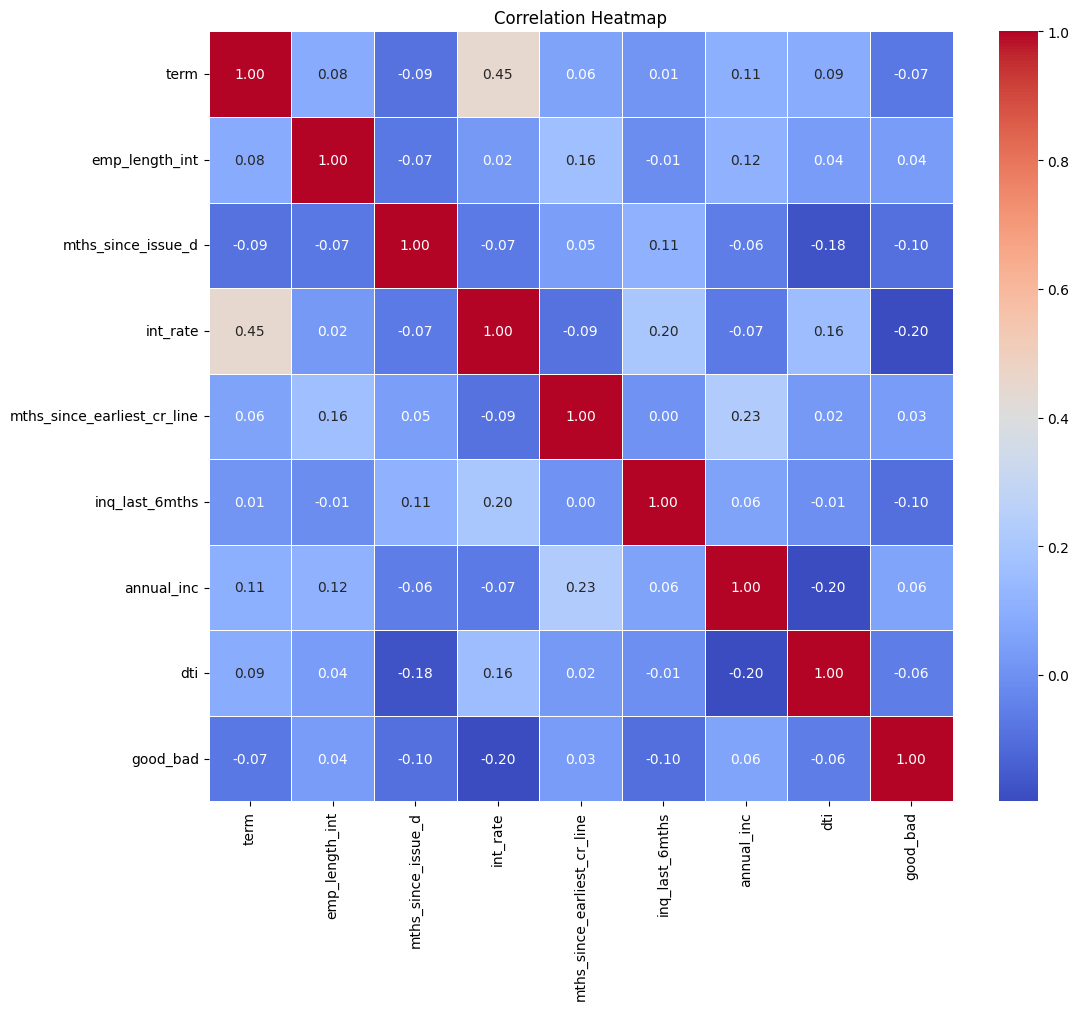

In [63]:
data_for_correlation = pd.concat([X_train_num_imputed, y_train_dropped], axis=1)


correlation_matrix_X_train_num = data_for_correlation.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_X_train_num, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [64]:
from sklearn.preprocessing import StandardScaler
def fit_scaler(data):
    '''  
    Fits a StandardScaler to the numerical data.

    This function computes the mean and standard deviation for each feature in the data to standardize them.

    Parameters:
    data (pd.DataFrame): DataFrame containing numerical data to be scaled.

    Returns:
    scaler (StandardScaler): A fitted StandardScaler object that can be used to transform the data.
    '''
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler
def transform_scaler(data, scaler):
    '''  
    Transforms the numerical data using a fitted StandardScaler.

    This function scales the data based on the mean and standard deviation computed by the fitted StandardScaler.

    Parameters:
    data (pd.DataFrame): DataFrame containing numerical data to be scaled.
    scaler (StandardScaler): A fitted StandardScaler object used for scaling the data.

    Returns:
    scaled_data (pd.DataFrame): DataFrame containing the scaled numerical data.
    '''
    scaled_array = scaler.transform(data)
    scaled_data = pd.DataFrame(scaled_array, index=data.index, columns=data.columns)
    return scaled_data

In [65]:
scaler = fit_scaler(X_train_num_imputed)
X_train_num_scale = transform_scaler(X_train_num_imputed, scaler)

In [66]:
def concat_data(num_data, cat_data):
    '''  
    Concatenates numerical and categorical data into a single DataFrame.

    This function ensures that the indices of the numerical and categorical data match before concatenation. If the indices do not match, the categorical data is reindexed to match the numerical data.

    Parameters:
    - num_data (pd.DataFrame): DataFrame containing numerical data.
    - cat_data (pd.DataFrame): DataFrame containing categorical data.

    Returns:
    - concatenated_data (pd.DataFrame): DataFrame with both numerical and categorical data concatenated along columns.
    '''
    if not num_data.index.equals(cat_data.index):
        cat_data = cat_data.reindex(num_data.index)
    concatenated_data = pd.concat([num_data, cat_data], axis=1)
    print(f'Numerical data shape  : {num_data.shape}')
    print(f'Categorical data shape: {cat_data.shape}')
    print(f'Concat data shape     : {concatenated_data.shape}')
    return concatenated_data

In [67]:
X_train_concat = concat_data(X_train_num_scale,X_train_cat_encoded_concat)

Numerical data shape  : (16055, 8)
Categorical data shape: (16055, 11)
Concat data shape     : (16055, 19)


In [68]:
def preprocess_data(data, num_cols,cat_cols,ohe_feat, ordinal_feat,num_imputer, cat_ohe_encoder,cat_ordinal_encoded,scaler):
    num_data = data[num_cols]
    cat_data = data[cat_cols]
    ohe_data = cat_data[ohe_feat]
    ordinal_data = cat_data[ordinal_feat]
    num_data_imputed = num_imputer_transform(num_data, num_imputer)
    cat_ohe_data_encoded = cat_OHE_encoder_transform(ohe_data,cat_ohe_encoder)
    cat_ordinal_data_encoded = cat_ordinal_encoder_transform(ordinal_data, cat_ordinal_encoded)
    num_data_scale = transform_scaler(num_data_imputed, scaler)
    cat_data_concat = pd.concat([cat_ohe_data_encoded, cat_ordinal_data_encoded], axis=1)
    clean_data = concat_data(num_data_scale, cat_data_concat)
    print(f'Mapped data shape  : {clean_data.shape}')
    return clean_data


In [69]:

ohe_feat = ['home_ownership', 'purpose','verification_status']  
ordinal_feat = ['grade'] 

X_train_clean = preprocess_data(
    data=X_train_dropped, 
    num_cols=num_cols, 
    cat_cols=cat_cols, 
    ohe_feat=ohe_feat, 
    ordinal_feat=ordinal_feat,
    num_imputer=num_imputer,
    cat_ohe_encoder = cat_ohe_encoder,
    cat_ordinal_encoded = cat_ordinal_encoded,
    scaler=scaler
)


Numerical data shape  : (16055, 8)
Categorical data shape: (16055, 12)
Concat data shape     : (16055, 20)
Mapped data shape  : (16055, 20)


In [70]:
X_valid_clean = preprocess_data(
    data=X_valid, 
    num_cols=num_cols,
    cat_cols=cat_cols, 
    ohe_feat=ohe_feat, 
    ordinal_feat=ordinal_feat,
    num_imputer=num_imputer,
    cat_ohe_encoder = cat_ohe_encoder,
    cat_ordinal_encoded = cat_ordinal_encoded,
    scaler=scaler
)

Numerical data shape  : (4080, 8)
Categorical data shape: (4080, 12)
Concat data shape     : (4080, 20)
Mapped data shape  : (4080, 20)


In [72]:
X_test = read_data('./dataset/pd_loan_data_test.csv')

Data shape raw               :  (3600, 14)
Number of duplicate order id :  0
Data shape after dropping    :  (3600, 14)
Data shape final             :  (3600, 14)


In [73]:
X_test_clean = feature_engineering(X_test)

In [75]:
X_test_clean = preprocess_data(
    data=X_test_clean, 
    num_cols=num_cols, 
    cat_cols=cat_cols, 
    ohe_feat=ohe_feat, 
    ordinal_feat=ordinal_feat,
    num_imputer=num_imputer,
    cat_ohe_encoder = cat_ohe_encoder,
    cat_ordinal_encoded = cat_ordinal_encoded,
    scaler=scaler
)

Numerical data shape  : (3600, 8)
Categorical data shape: (3600, 12)
Concat data shape     : (3600, 20)
Mapped data shape  : (3600, 20)


In [76]:

def extract_cv_results(cv_obj):
    '''  
    Extracts the best scores and parameters from a cross-validation object.

    Parameters:
    cv_obj (GridSearchCV or RandomizedSearchCV): The fitted cross-validation object.

    Returns:
    best_train_score (float): The mean training score of the best model.
    best_valid_score (float): The best validation score.
    best_params (dict): The hyperparameters of the best model.
    '''

    best_train_score = cv_obj.cv_results_['mean_train_score'][cv_obj.best_index_]

    best_valid_score = cv_obj.best_score_  
    
    best_params = cv_obj.best_params_
    
    return best_train_score, best_valid_score, best_params


im using stratified since the data is imbalanced,
but before we create a best model, we need to use scoring that threshold independent, which is ROC - AUC, so our model can distinguishes between classes

In [77]:
from sklearn.model_selection import StratifiedKFold

stratified_cv = StratifiedKFold(n_splits=5)

In [78]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

param_grid_base = {'strategy': ['stratified']}
baseline_model = DummyClassifier()
reg_base = GridSearchCV(baseline_model, param_grid_base, scoring='f1_macro', return_train_score=True)
reg_base.fit(X_train_clean, y_train_dropped)


GridSearchCV(estimator=DummyClassifier(),
             param_grid={'strategy': ['stratified']}, return_train_score=True,
             scoring='f1_macro')

In [79]:
train_base, valid_base, best_param_base = extract_cv_results(reg_base)

print(f'Train score - Baseline model: {train_base}')
print(f'Valid score - Baseline model: {valid_base}')
print(f'Best Params - Baseline model: {best_param_base}')

Train score - Baseline model: 0.5018774008452482
Valid score - Baseline model: 0.49522035295914507
Best Params - Baseline model: {'strategy': 'stratified'}


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# F1 scorer
f1_scorer = make_scorer(f1_score)

# Parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],         # regularisasi
    'penalty': ['l2'],               # l1 kalau pakai solver='liblinear'
    'solver': ['lbfgs'],             # untuk L2 penalty, 'liblinear' juga bisa
    'max_iter': [100, 200, 300]
}

# Inisialisasi Logistic Regression dengan class_weight='balanced'
lr_model = LogisticRegression(class_weight='balanced')

# GridSearchCV pakai f1_score untuk penilaian model
clas_lr = GridSearchCV(lr_model, param_grid_lr, scoring='f1_macro', return_train_score=True)

# Fit model ke data training
clas_lr.fit(X_train_clean, y_train_dropped)


d:\software\New folder\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\software\New folder\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\software\New folder\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\software\New folder\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             return_train_score=True, scoring='f1_macro')

In [81]:
train_lr, valid_lr, best_param_lr = extract_cv_results(clas_lr)

print(f'Train score - Logistic Regression (F1): {train_lr}')
print(f'Valid score - Logistic Regression (F1): {valid_lr}')
print(f'Best Params - Logistic Regression: {best_param_lr}')


Train score - Logistic Regression (F1): 0.5480513667219037
Valid score - Logistic Regression (F1): 0.5452727621466482
Best Params - Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [82]:
from sklearn.ensemble import RandomForestClassifier


param_grid_rf = {
    'n_estimators': [50, 100,150],         
    'max_depth': [10, 20,50],             
    'min_samples_split': [5,10,25],         
    'min_samples_leaf': [2, 5,10],       
    'bootstrap': [True]                
}

rf_model = RandomForestClassifier(class_weight='balanced')

clas_rf = GridSearchCV(rf_model, param_grid_rf, scoring='f1_macro', return_train_score=True,cv=stratified_cv)
clas_rf.fit(X_train_clean, y_train_dropped)

d:\software\New folder\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\software\New folder\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\software\New folder\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\software\New folder\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, 50],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 10, 25],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='f1_macro')

In [83]:
train_rf, valid_rf, best_param_rf = extract_cv_results(clas_rf)

print(f'Train score - Decision Tree model: {train_rf}')
print(f'Valid score - Decision Tree model: {valid_rf}')
print(f'Best Params - Decision Tree model: {best_param_rf}')

Train score - Decision Tree model: 0.7972825584407457
Valid score - Decision Tree model: 0.589612312135889
Best Params - Decision Tree model: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150}


In [84]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 150],       
    'max_depth': [3, 6, 10],             
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.8, 0.9, 1.0],       
    'colsample_bytree': [0.8, 0.9, 1.0], 
    'gamma': [0, 0.1, 0.2]               
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Setup GridSearchCV with AUC as the scoring metric
clas_xgb = GridSearchCV(xgb_model, param_grid_xgb, scoring='f1_macro', return_train_score=True)

# Fit the model
clas_xgb.fit(X_train_clean, y_train_dropped)




d:\software\New folder\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:23:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\software\New folder\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\software\New folder\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\software\New folder\Lib\site-packages\xgboost\

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 0.9, 1.0]},
             return_train_score=True, scoring='f1_macro')

In [85]:
# Extract cross-validation results
train_xgb, valid_xgb, best_param_xgb = extract_cv_results(clas_xgb)

# Print results
print(f'Train score - XGBoost model: {train_xgb}')
print(f'Valid score - XGBoost model: {valid_xgb}')
print(f'Best Params - XGBoost model: {best_param_xgb}')

Train score - XGBoost model: 0.9998088565288505
Valid score - XGBoost model: 0.5219412984226657
Best Params - XGBoost model: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150, 'subsample': 0.8}


In [86]:
summary_df = pd.DataFrame(
    data={
        'model': ['Baseline',  'Random FOrest', 'Logistic Regression','XGB'],
        'train_score': [train_base, train_rf, train_lr,train_xgb],
        'valid_score': [valid_base, valid_rf,valid_lr, valid_xgb],
        'best_params': [best_param_base, best_param_rf, best_param_lr,best_param_xgb]
    }
)

summary_df['train_score'] 
summary_df['valid_score']
summary_df

,model,train_score,valid_score,best_params
0,Baseline,0.501877,0.495220,{'strategy': 'stratified'}
1,Random FOrest,0.797283,0.589612,"{'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150}"
2,Logistic Regression,0.548051,0.545273,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}"
3,XGB,0.999809,0.521941,"{'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150, 'subsample': 0.8}"


In [87]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [88]:
y_valid_pred = clas_rf.predict(X_valid_clean)

In [89]:
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

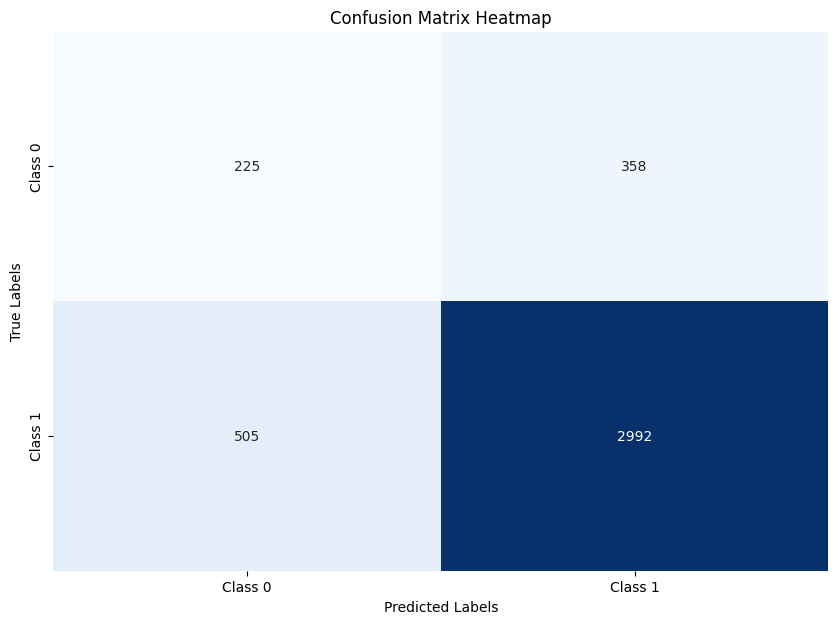

In [92]:
report = classification_report(y_valid, y_valid_pred, output_dict=True)

precision = {class_name: report[class_name]['precision'] for class_name in report if class_name != 'accuracy'}
recall = {class_name: report[class_name]['recall'] for class_name in report if class_name != 'accuracy'}
f1 = {class_name: report[class_name]['f1-score'] for class_name in report if class_name != 'accuracy'}

conf_matrix_df = pd.DataFrame(conf_matrix, index=['Class 0', 'Class 1'], columns=['Class 0', 'Class 1'])


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [93]:
print("Precision per class:")
for class_name, precision_score in precision.items():
    print(f"{class_name}: {precision_score:.2f}")

print("\nRecall per class:")
for class_name, recall_score in recall.items():
    
    print(f"{class_name}: {recall_score:.2f}")

print("\nF1-Score per class:")
for class_name, f1_score in f1.items():
    print(f"{class_name}: {f1_score:.2f}")


Precision per class:
0: 0.31
1: 0.89
macro avg: 0.60
weighted avg: 0.81

Recall per class:
0: 0.39
1: 0.86
macro avg: 0.62
weighted avg: 0.79

F1-Score per class:
0: 0.34
1: 0.87
macro avg: 0.61
weighted avg: 0.80


searching for better threshold

In [96]:
from sklearn.metrics import precision_recall_curve

y_probs = clas_rf.predict_proba(X_valid_clean)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_valid, y_probs)
# im using f1 score to tune the threshold since it give balance between precision and recall
f1_scores = 2 * (precision * recall) / (precision + recall)

optimal_idx = (f1_scores).argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

y_test_pred_optimal = (y_probs >= optimal_threshold).astype(int)


Optimal Threshold: 0.15437731665457363


In [98]:
from sklearn.metrics import f1_score

f1 = f1_score(y_valid, y_test_pred_optimal, average='macro')

print(f"F1-Score with Tuned Threshold: {f1}")


F1-Score with Tuned Threshold: 0.4615283093572654


In [100]:
import pickle


# Menyimpan model ke file pickle
with open('./models/RandomForest.pkl', 'wb') as f:
    pickle.dump(clas_rf, f)


##  Final Model: Random Forest

I selected **Random Forest** as the final model because it achieved the best balance between training and validation performance compared to the other models.

###  Model Performance Comparison

| Model               | Train Score | Validation Score |
|---------------------|-------------|------------------|
| Baseline            | 0.5019      | 0.4952           |
| Logistic Regression | 0.5481      | 0.5453           |
| **Random Forest**   | 0.7973      | **0.5896**       |
| XGBoost             | 0.9998      | 0.5219           |

- **Random Forest** achieved the **highest validation score** of **0.5896**.
- It generalizes better than **XGBoost**, which overfit the training data (train score ~1.0).
- It outperformed **Logistic Regression** and the **Baseline** model by a noticeable margin.

###  Why Random Forest?
- It effectively handles **non-linear relationships** and **feature interactions**.
- It is **robust to overfitting** thanks to the ensemble of decision trees.
- Among all tested models, Random Forest provided the **best validation performance**, which is crucial for evaluating how well the model performs on unseen data.


In [120]:
# Predict the test data
y_test_pred = clas_rf.predict(X_test_clean)

# Kalau classification dan kamu mau lihat probability juga
# y_test_proba = final_model.predict_proba(X_test_clean)

# Tambahin ke DataFrame test
test_result = X_test_clean.copy()
test_result['predicted_label'] = y_test_pred

# Simpan ke file CSV (optional)
test_result.to_csv('final_test_predictions.csv', index=False)
